<h1 style="text-align:center;">ESCUELA POLITÉCNICA NACIONAL</h1>
<h2 style="text-align:center;">FACULTAD DE INGENIERÍA DE SISTEMAS</h2>
<h3 style="text-align:center;">INGENIERÍA EN CIENCIAS DE LA COMPUTACIÓN</h3>

**PERÍODO ACADÉMICO:** 2025-A  
**ASIGNATURA:** ICCD412 Métodos Numéricos  
**GRUPO:** GR2  
**TIPO DE INSTRUMENTO:** Proyecto   
**FECHA DE ENTREGA LÍMITE:** ..   
**ALUMNO:** Murillo Juan, Sangucho Eddy, Morales Presly

## Librerías a utilizar
* pandas 
* seaborn 
* matplotlib
* numpy
* scipy 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as statsCorr

# Limpieza DE CSV

## Creación del DataFrame
Utilizamos pandas para crear un DataFrame a partir del csv.

In [3]:
df = pd.read_csv("Train.csv")

## Revisión del tipo de datos
Realizamos esta revisión porque pandas asigna un tipo de dato que él considera adecuado y a veces el tipo de dato es erróneo.

In [4]:
print(df.dtypes)

date_time               object
is_holiday              object
air_pollution_index      int64
humidity                 int64
wind_speed               int64
wind_direction           int64
visibility_in_miles      int64
dew_point                int64
temperature            float64
rain_p_h               float64
snow_p_h               float64
clouds_all               int64
weather_type            object
weather_description     object
traffic_volume           int64
dtype: object


## Conclusión del paso anterior
Nos damos cuenta de que están mal asignadas las categóricas y el date_time no está en formato datetime64.

In [5]:
df["date_time"] = df["date_time"].astype("datetime64[ns]")
df["weather_type"] = df["weather_type"].astype("category")
df["weather_description"] = df["weather_description"].astype("category")

## Limpieza de columnas duplicadas
Revisamos el número de datos de cada categoría de weather_description y nos damos cuenta de que hay un duplicado sky is clear y Sky is clear

In [6]:
print(df['weather_description'].value_counts())

weather_description
sky is clear                           7524
mist                                   4047
overcast clouds                        3972
broken clouds                          3379
light rain                             2442
scattered clouds                       2294
Sky is Clear                           1709
few clouds                             1568
light snow                             1280
moderate rain                          1105
haze                                    902
light intensity drizzle                 703
heavy snow                              587
fog                                     567
drizzle                                 460
proximity thunderstorm                  345
heavy intensity rain                    311
snow                                    190
thunderstorm                             66
proximity shower rain                    54
thunderstorm with heavy rain             42
heavy intensity drizzle                  40
thunderstorm

In [7]:
df["weather_description"] = (df["weather_description"].str.lower()).str.strip()
df["weather_description"] = df["weather_description"].astype("category")
print(df['weather_description'].value_counts())

weather_description
sky is clear                           9233
mist                                   4047
overcast clouds                        3972
broken clouds                          3379
light rain                             2442
scattered clouds                       2294
few clouds                             1568
light snow                             1280
moderate rain                          1105
haze                                    902
light intensity drizzle                 703
heavy snow                              587
fog                                     567
drizzle                                 460
proximity thunderstorm                  345
heavy intensity rain                    311
snow                                    190
thunderstorm                             66
proximity shower rain                    54
thunderstorm with heavy rain             42
heavy intensity drizzle                  40
thunderstorm with light rain             35
proximity th

## Trabajo de limpieza con la variable temperatura

In [8]:
#Eliminamos la columna de isHoliday porque aporta ruido y porque no lo consideramos para el modelo, ademas vimos que existen solo 43 datos de esta sobre 33750
df.drop(columns="is_holiday", inplace=True)#Ponemos inplace=True porque sino no cambia el df

#Aca veremos las variables categoricas y su relacion ()
df_test = df[["weather_type","weather_description", "traffic_volume"]]
# Solo mantenemos combinaciones que realmente aparecen en los datos
df_grp = df_test.groupby(["weather_type", "weather_description"], as_index=False, observed=True).mean()
print(df_grp)

#Vemos el tamanio para ver que metodo de categorico a numerico podemos usar 
df_count = df_test.groupby(["weather_type", "weather_description"], as_index=False, observed=True).size()
print(df_count)


    weather_type                  weather_description  traffic_volume
0          Clear                         sky is clear     3098.786202
1         Clouds                        broken clouds     3481.830719
2         Clouds                           few clouds     3569.742347
3         Clouds                      overcast clouds     3302.797080
4         Clouds                     scattered clouds     3841.502616
5        Drizzle                              drizzle     3041.732609
6        Drizzle              heavy intensity drizzle     3158.500000
7        Drizzle              light intensity drizzle     3309.857752
8        Drizzle                       shower drizzle     2010.000000
9            Fog                                  fog     2740.603175
10          Haze                                 haze     3638.919069
11          Mist                                 mist     2943.952310
12          Rain                        freezing rain     4314.000000
13          Rain    

In [9]:
#std Desviacion estandar (Estadistica)
print(df.describe(include="all")) #-> De aqui influimos que temperature es en kelvin por los min y max  
 #Trabajamos con Kelvin para el calculo, transformamos a celsius para las presentaciones

                            date_time  air_pollution_index      humidity  \
count                           33750         33750.000000  33750.000000   
unique                            NaN                  NaN           NaN   
top                               NaN                  NaN           NaN   
freq                              NaN                  NaN           NaN   
mean    2015-02-17 16:33:28.106666496           154.841422     71.209007   
min               2012-10-02 09:00:00            10.000000     13.000000   
25%               2013-08-16 01:15:00            83.000000     60.000000   
50%               2015-07-26 07:30:00           155.000000     72.000000   
75%               2016-07-28 09:45:00           228.000000     85.000000   
max               2017-05-17 23:00:00           299.000000    100.000000   
std                               NaN            83.735515     16.852248   

          wind_speed  wind_direction  visibility_in_miles     dew_point  \
count   3375

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            33750 non-null  datetime64[ns]
 1   air_pollution_index  33750 non-null  int64         
 2   humidity             33750 non-null  int64         
 3   wind_speed           33750 non-null  int64         
 4   wind_direction       33750 non-null  int64         
 5   visibility_in_miles  33750 non-null  int64         
 6   dew_point            33750 non-null  int64         
 7   temperature          33750 non-null  float64       
 8   rain_p_h             33750 non-null  float64       
 9   snow_p_h             33750 non-null  float64       
 10  clouds_all           33750 non-null  int64         
 11  weather_type         33750 non-null  category      
 12  weather_description  33750 non-null  category      
 13  traffic_volume       33750 non-

date_time              0
air_pollution_index    0
humidity               0
wind_speed             0
wind_direction         0
visibility_in_miles    0
dew_point              0
temperature            0
rain_p_h               0
snow_p_h               0
clouds_all             0
weather_type           0
weather_description    0
traffic_volume         0
dtype: int64


<Axes: xlabel='weather_type'>

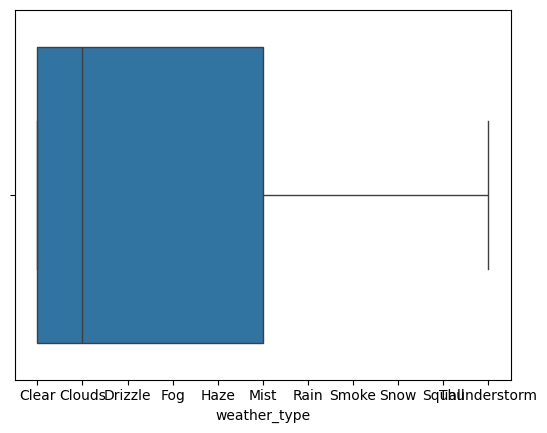

In [10]:
#Dado que no se cuenta con información sobre la ubicación geográfica o el clima específico del lugar donde se recolectaron los datos 
#Por tanto, para evitar sesgar el análisis y el modelo, se opta por conservar estos valores. 
#Solo se marcan como NaN, como 0 K, que corresponden claramente a errores de medición o registros faltantes.

df.loc[df["temperature"] == 0, "temperature"] = pd.NA 
#print(df.isnull().sum())

#Como son 10 los rellenamos con la media de la hora. Métodos avanzados pueden introducir sesgos o sobreajustar en conjuntos pequeños o con poca información.
df["temperature"] = df.groupby(df["date_time"].dt.hour)["temperature"].transform(lambda x: x.fillna(x.mean()))

#Info como memoria etc
df.info()
print(df.isnull().sum())

#Diagrama de caja
sns.boxplot(x="weather_type", data=df)

## Dividimos los datos en 80/20 para hacerTrain y Test 

Esto lo realizamos para comparar los resultados de nuestro modelo con los medidos y registrados en la tabla y ver cuanta exactitud tiene.


In [11]:
df = df.sample(frac=1, random_state=42)#Barajeamos las filas
cut = int(len(df) * 0.8)
df_train = df.iloc[:cut].copy() #80%
df_test  = df.iloc[cut:].copy() #20%

## Unir weather_type y  weather_description
Unimos ambos porque están directamente relacionados y para simplificar la dimensión de la tabla

In [12]:
# Solo mantener combinaciones que realmente aparecen en los datos y tienen traffic volume
df_test_sub = df[["weather_type","weather_description", "traffic_volume"]]
df_grp = df_test_sub.groupby(["weather_type", "weather_description"], as_index=False, observed=True).mean()
df_count = df_test_sub.groupby(["weather_type", "weather_description"], as_index=False, observed=True).size()
print(df_count)

    weather_type                  weather_description  size
0          Clear                         sky is clear  9233
1         Clouds                        broken clouds  3379
2         Clouds                           few clouds  1568
3         Clouds                      overcast clouds  3972
4         Clouds                     scattered clouds  2294
5        Drizzle                              drizzle   460
6        Drizzle              heavy intensity drizzle    40
7        Drizzle              light intensity drizzle   703
8        Drizzle                       shower drizzle     1
9            Fog                                  fog   567
10          Haze                                 haze   902
11          Mist                                 mist  4047
12          Rain                        freezing rain     2
13          Rain                 heavy intensity rain   311
14          Rain          light intensity shower rain     8
15          Rain                        

## Conclusión del paso anterior
Vemos que no podemos realizar One-Hot como método para pasar de variable categórica a numérica porque tenemos muchos valores en ciertas filas y en otros tenemos muy pocos.
Además, recurrimos al método Target Encoding modificado porque el normal puede producir goteo.

## Target Encoding 

Explication

In [13]:
#Con libreria el suavizado 
from category_encoders import TargetEncoder
encoder = TargetEncoder()
encoded = encoder.fit_transform(
    df_test[["weather_type", "weather_description"]],
    df_test["traffic_volume"]
)
df_test = df_test.copy()
# Crea la columna con el promedio de las dos codificaciones (por fila)
df_test['weather_encodedbySKlearn'] = encoded.mean(axis=1)
# Agrupar para obtener la media del encoding por grupo (combinación única)
encoded_group = df_test.groupby(["weather_type", "weather_description"], observed=True)["weather_encodedbySKlearn"].mean().reset_index()
# Ahora `encoded` es un DataFrame con dos columnas codificadas,
# para combinar en una sola columna (promedio o similar):
stats = df_count.merge(encoded_group, on=["weather_type", "weather_description"], how="left")
#Lo agregamos al df si lo vemos necesario
df = df.merge(stats[["weather_type", "weather_description", "weather_encodedbySKlearn"]], on = ["weather_type", "weather_description"],how = "left")
stats

,weather_type,weather_description,size,weather_encodedbySKlearn
0,Clear,sky is clear,9233,3098.860847
1,Clouds,broken clouds,3379,3569.389978
2,Clouds,few clouds,1568,3452.076722
3,Clouds,overcast clouds,3972,3423.944488
4,Clouds,scattered clouds,2294,3663.833884
5,Drizzle,drizzle,460,3210.923951
6,Drizzle,heavy intensity drizzle,40,3132.877222
7,Drizzle,light intensity drizzle,703,3284.416491
8,Drizzle,shower drizzle,1,3155.668077
9,Fog,fog,567,2553.570692


## Matriz de correlación

Explicación y decir cuáles elegimos con base en el mapa de calor

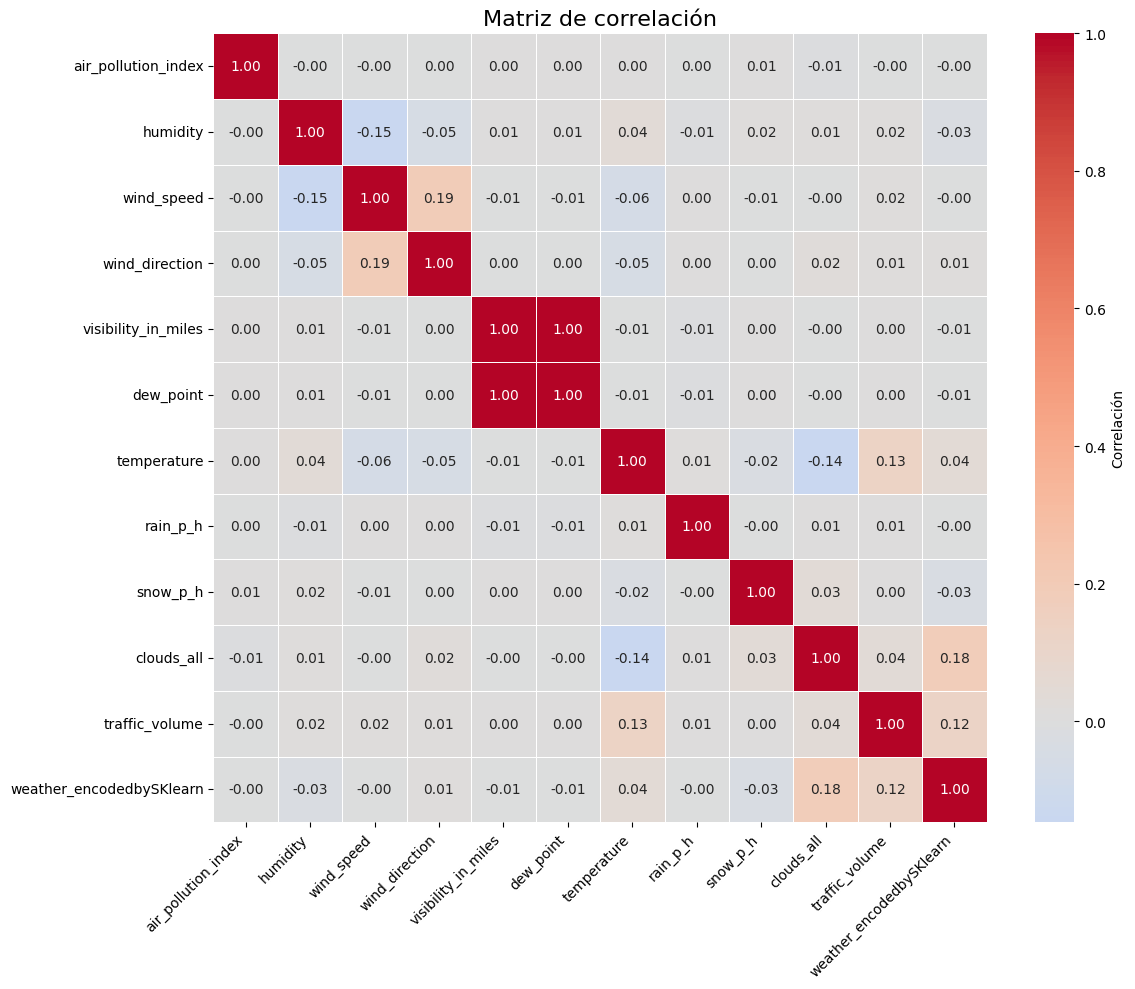

In [14]:
# seleccionamos columnas numéricas
cols = df.select_dtypes(include=['number']).columns
# Aseguraamos de que todas las columnas existan y sean numéricas
df_corr = df[cols].copy()
# Calcular la matriz de correlación
correlation_matrix = df[cols].corr()
# visualización del heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            linewidths=0.5, fmt=".2f", cbar_kws={'label': 'Correlación'})

# Título y estilo
plt.title("Matriz de correlación", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Matriz de correlación de Weather type y Weather Description
Explicar que la nieve tiene más

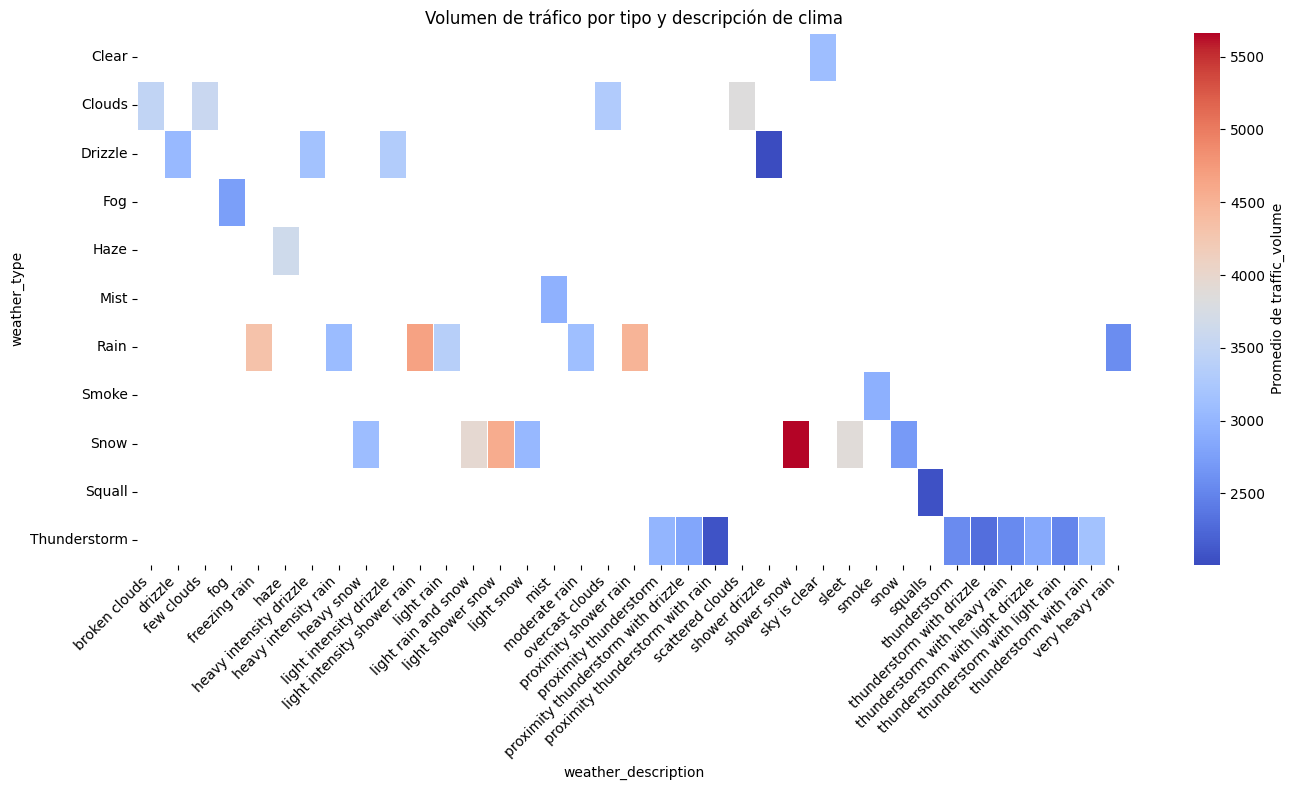

In [19]:
# Crea la tabla pivote
pivot_tv = df_grp.pivot(index='weather_type',
                        columns='weather_description',
                        values='traffic_volume')

# lienzo
plt.figure(figsize=(14, 8))
# Dibuajar el heatmap
sns.heatmap(pivot_tv,cmap="coolwarm",
            linewidths=.5, cbar_kws={'label': 'Promedio de traffic_volume'})
# Titulo y estilo
plt.title("Volumen de tráfico por tipo y descripción de clima")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Volumen de Trafico segun el Tipo de Clima:

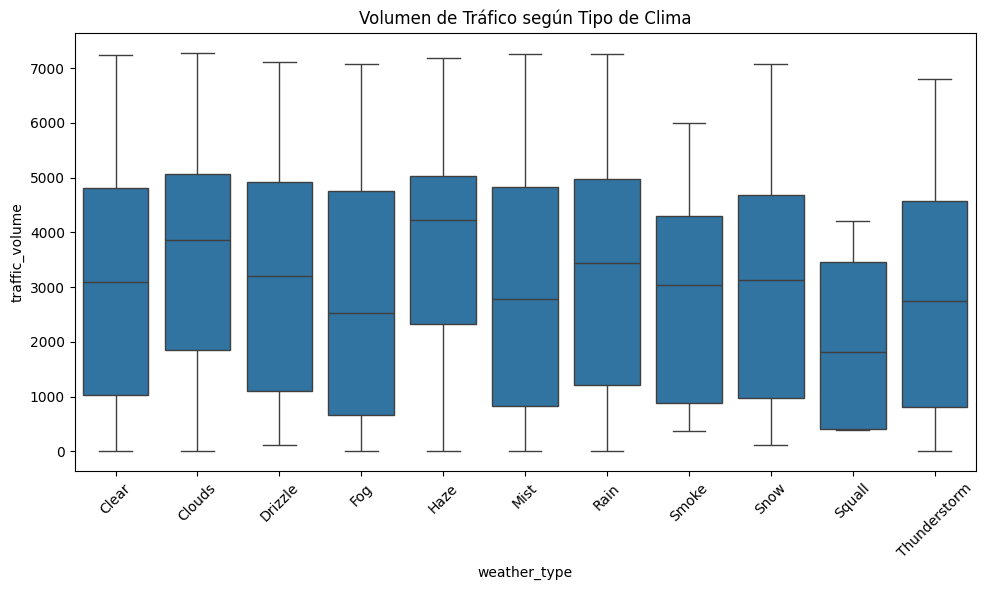

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="weather_type", y="traffic_volume", data=df)
plt.xticks(rotation=45)
plt.title("Volumen de Tráfico según Tipo de Clima")
plt.tight_layout()
plt.show()

## Relación Humedad vs Volumen de trafico 

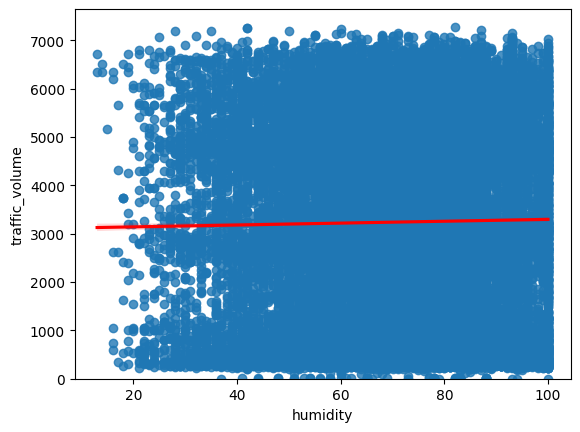

In [17]:
sns.regplot(
    x="humidity",
    y="traffic_volume",
    data=df,
    line_kws={'color': 'red'}
)
plt.ylim(0,)

plt.show()